In [1]:
from libraries import * 
from preprocessing import downloading_loading_processed_files
from utils import enframe
warnings.filterwarnings("ignore")

# selecting GPU if possible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"running on GPU = {str(device) == 'cuda'}")

# (down)loading split datasets, can be run twice if kernel dies 1st time
train_set, validation_set, test_set = downloading_loading_processed_files(
    downsampling=False)
print(f"loading of datasets done")

# setting up computational parameters
if device == "cuda":
    num_workers, pin_memory = 4, True
else:
    num_workers, pin_memory = 0, False

running on GPU = False
loading of datasets done


In [2]:
# all element in dataset are shpae 78*13
# about 2,8 to 2,9% of the inputs have nan in it (preprocessing problematic: dataset should be filtered
def remove_nan_in(dataset):
    not_nan_entries = []
    for i, (lmfcc, sample_rate, label, speaker_id, utterance_number) in enumerate(dataset):
        if not np.isnan(lmfcc).any():
            not_nan_entries.append(i)
    return np.array(dataset)[not_nan_entries]

train_set = remove_nan_in(train_set)
validation_set = remove_nan_in(validation_set)

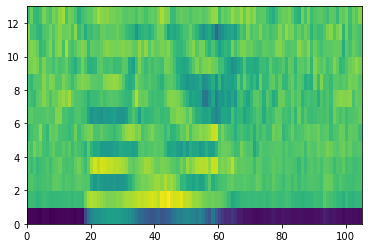

In [3]:
plt.pcolormesh(train_set[10][0].T);

In [4]:
def pad_sequence(batch):
    """ 
    desc: make all tensor in a batch the same length as the longest sequence by padding with zeros 
    """
    batch = [torch.from_numpy(item) for item in batch]
    batch = torch.nn.utils.rnn.pad_sequence(batch, batch_first=True, padding_value=0.)
    return batch.permute(0, 2, 1)  # in each tensor, target first, tensor second

# encoding each word using its index in the list of labels
def label_to_index(word):
    """ 
    desc: return the position of the word in labels 
    """
    return torch.tensor(labels.index(word))
    
def collate_fn(batch):
    """ 
    desc: turn audio's list batch into two batch tensors for model 
    """
    tensors, targets = [], []

    # Gather in lists, and encode labels as indices
    for waveform, _, label, *_ in batch:
        tensors += [waveform]
        targets += [label_to_index(label)]

    # Group the list of tensors into a batched tensor
    tensors = pad_sequence(tensors)
    targets = torch.stack(targets)
    return tensors, targets

    
# sets in to dataloaders
batch_size = 16
train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size, shuffle=True, collate_fn=collate_fn,
    num_workers=num_workers, pin_memory=pin_memory)
validation_loader = torch.utils.data.DataLoader(
    validation_set, batch_size=batch_size, shuffle=False, drop_last=False,
    collate_fn=collate_fn, num_workers=num_workers, pin_memory=pin_memory)
test_loader = torch.utils.data.DataLoader(
    validation_set, batch_size=batch_size, shuffle=False, drop_last=False,
    collate_fn=collate_fn, num_workers=num_workers, pin_memory=pin_memory)
print(f"set up of dataloader done")

set up of dataloader done


In [5]:
# MODEL (adapted from there: https://www.kaggle.com/code/talmanr/cnn-with-pytorch-using-mel-features/notebook)
class CnnAudioNet(nn.Module):
    def __init__(self,NumClasses):
        super(CnnAudioNet,self).__init__()
        self.NumClasses = NumClasses
        self.Fc_features = 128
        self.C1 = nn.Conv2d(1,32,3,padding=1)
        self.C2 = nn.Conv2d(32,32,5,padding=1)
        self.BN1 = nn.BatchNorm2d(32)  # change size of batch norm?
        self.fc1 = nn.Linear(1536,128)
        self.fc2 = nn.Linear(128, self.NumClasses)
        self.maxpool1 = nn.MaxPool2d(2,2)
        self.dropout = nn.Dropout(0.25)
        
        self.C3 = nn.Conv2d(32,64,5,padding=1)
        self.BN2 = nn.BatchNorm2d(64)


    def forward(self,x):        
        x = F.relu(self.BN1(self.C1(x)))
        x = self.maxpool1(F.relu(self.BN1(self.C2(x))))
        
        x = self.maxpool1(F.relu(self.BN2(self.C3(x))))
                
        x = (x.view(-1,np.prod(x.shape[1:]))) # self.dropout
        # dim to know here for fully connected
        # print(x.shape)
        x = self.dropout(self.fc1(x))
        x = self.fc2(x)
        return x

labels = sorted(list(set(datapoint[2] for datapoint in train_set)))  

model = CnnAudioNet(len(labels))
model.to(device)  # convert initialized model to CUDA optimized model
optimizer = optim.Adam(params=model.parameters(), lr=0.001)

In [ ]:
# run first with - F.nll_loss 10 iterations, than +F.nll_loss 20 iterations, it works starts to have results, lr 1e-3
model.train()

train_loss_history, nb_epochs = [], 20
valid_loss_history = []
for epoch in tqdm(range(nb_epochs)):
    # train and eval train loss
    train_loss = 0.0
    for batch_idx, (data, target) in enumerate(train_loader):

        print(target)
        target = target.to(device)
        data = (data-data.mean())/data.std()
        data = data.to(device, dtype=torch.float)
        output = model(data.unsqueeze(1)) #bug
        _, pred = torch.max(output,1)

        # negative log-likelihood for tensor of size (batch x 1 x n_output)
        loss = F.nll_loss(output, target)

        optimizer.zero_grad()  
        loss.backward()  
        optimizer.step()

        train_loss += loss.item()
    print('Train batch loss: {:.6f},'.format(train_loss))
    train_loss_history.append(loss)
    
#     # eval val loss
#     with torch.no_grad():
#         model.eval()
#         valid_loss = 0 
#         for data, target in validation_loader:
            
#             target = target.to(device)
#             data = data.to(device, dtype=torch.float)
#             output = model(data.unsqueeze(1))
#             _,pred = torch.max(output,1)
            
#             loss = F.nll_loss(output, target)
#             valid_loss += loss.item()
#     valid_loss_history.append(valid_loss)
            
            

    
plt.plot(train_loss_history, "r--", label="train_loss")
# plt.plot(valid_loss_history, "g--", label="val_loss")
plt.legend();

  0%|          | 0/20 [00:00<?, ?it/s]

tensor([34, 21,  0, 34, 24, 16, 32, 10, 18, 14, 17, 10,  2, 28, 26, 11])


In [ ]:
pred

In [ ]:
target

In [ ]:
from preprocessing import Preprocessing  # run first with - F.nll_loss 10 iterations, than +F.nll_loss 20 iterations, it works starts to have results, lr 1e-3



processor = Preprocessing(train_set, validation_set, test_set)
model.train()

train_loss_history, nb_epochs = [], 20
valid_loss_history = []
for epoch in tqdm(range(nb_epochs)):
    
    # train and eval train loss
    train_loss = 0.0
    for batch_idx, (data, target) in enumerate(train_loader):

        print(target)
        target = target.to(device)
        data = (data-data.mean())/data.std()

        data = data.to(device, dtype=torch.float)
        output = model(data.unsqueeze(1))
        _, pred = torch.max(output,1)

        # negative log-likelihood for tensor of size (batch x 1 x n_output)
        loss = F.nll_loss(output, target)

        optimizer.zero_grad()  
        loss.backward()  
        optimizer.step()

        train_loss += loss.item()
    print('Train batch loss: {:.6f},'.format(train_loss))
    train_loss_history.append(loss)
    
#     # eval val loss
#     with torch.no_grad():
#         model.eval()
#         valid_loss = 0 
#         for data, target in validation_loader:
            
#             target = target.to(device)
#             data = data.to(device, dtype=torch.float)
#             output = model(data.unsqueeze(1))
#             _,pred = torch.max(output,1)
            
#             loss = F.nll_loss(output, target)
#             valid_loss += loss.item()
#     valid_loss_history.append(valid_loss)
            
            

    
plt.plot(train_loss_history, "r--", label="train_loss")
# plt.plot(valid_loss_history, "g--", label="val_loss")
plt.legend();

In [ ]:
np.max(train_set[100][0])